# Training an image classifier

Do the following steps in order:
1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the on the test data

## 1. Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# The output of torchvision datasets are PILImage of range [0,1].
# We transform them to Tensors of normalized range [-1,1].

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


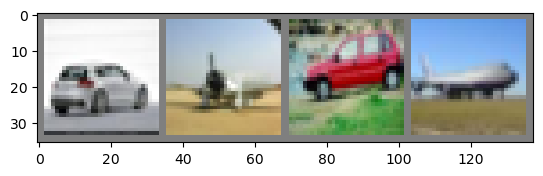

car   plane car   plane


In [3]:
# Let us show some of the training images, for fun

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def show_img(img):
    img = img / 2 + 0.5     #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
show_img(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Define a Convolutional Neural Network

In [4]:
# copy the neural network from the Neural Networks section before 
# and modify it to take 3-channel images(instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


## 3. Define a Loss function and optimizer

In [15]:
# Let's use a Classification Cross-Entropy loss and SGD with momentum

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [16]:
# This is when things start to get interesting.
# We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

for epoch in range(2): #loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  #print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
print('Finished Training')

# save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
        

[1,  2000] loss: 1.200
[1,  4000] loss: 1.195
[1,  6000] loss: 1.184
[1,  8000] loss: 1.191
[1, 10000] loss: 1.175
[1, 12000] loss: 1.182
[2,  2000] loss: 1.090
[2,  4000] loss: 1.096
[2,  6000] loss: 1.100
[2,  8000] loss: 1.093
[2, 10000] loss: 1.123
[2, 12000] loss: 1.076
Finished Training


## 5. Test the network on the test data

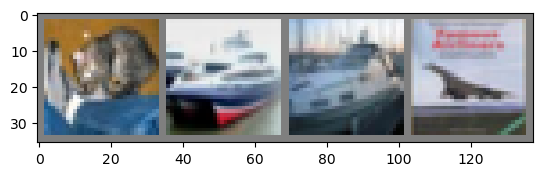

GroundTruth:  cat   ship  ship  plane


In [17]:
# 뭐시기

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
show_img(torchvision.utils.make_grid(images))
# print labels
print('GroundTruth: ',' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [18]:
# load back in our saved model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted:', ''.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted: cat  car  car  ship 


In [20]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # claculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test iamges: {100*correct // total}%')

Accuracy of the network on the 10000 test iamges: 59%
